In [80]:
#패키지 임포트
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

#Pytorch 라이브러리 임포트
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler

import copy

import warnings
warnings.filterwarnings(action='ignore')

## Data load and pre-processing

In [87]:
# data 불러오기
train_data = pd.read_csv('tobigs14-mnist-competition/train_df.csv')
test_data = pd.read_csv('tobigs14-mnist-competition/test_df.csv')

In [88]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
X_train = train_data.drop('label',axis = 1).values
y_train = train_data['label'].values

X_test = test_data.iloc[:,1:].values

In [90]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (18000, 784))

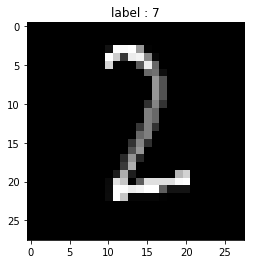

In [91]:
# 출력 해보기

index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [92]:
# scaling
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print('maximum value after scaling:', X_train.max(),
      '\nminimum value after scaling:' ,X_train.min())

maximum value after scaling: 1.0 
minimum value after scaling: 0.0


In [93]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


In [94]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [95]:
X_train = X_train.reshape((len(X_train),1,28,28))
X_val = X_val.reshape((len(X_val),1,28,28))
X_test = X_test.reshape((len(X_test),1,28,28))

In [96]:
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

In [97]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).long()
X_test = torch.from_numpy(X_test).float()

In [98]:
train_set = TensorDataset(X_train,y_train)
val_set = TensorDataset(X_val,y_val)

In [99]:
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
val_loader = DataLoader(val_set, batch_size=512,shuffle=True)
dataloaders = {'train':train_loader, 'val':val_loader} # 밑의 함수에서 phase에 따라 학습 및 평가를 진행하기 위해 dict타입으로 저장

 - data를 tensor로 변환 시킨다
 - TensorDataset을 이용해 X,y를 합친다
 - Dataloader를 이용해 배치를 나눠주고 데이터를 섞는다
 - Batch size: 512

In [77]:
#학습 및 평가를 진행하는 함수를 정의 한다
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    
    global train_loss_history
    global val_loss_history
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
                exp_lr_scheduler.step()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    
    print("Best val Acc: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## CNN(Convolutional Neural Network)생성

### CNN1
 - cnn 초기 모델인 lenet을 이용해서 만든 기본 모델
 - batchnormalization, dropout, weight initialization 등 처리 X

In [23]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Linear(16*4*4,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10))
    
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

### CNN2
 - batchnormalization과 dropout사용

In [24]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,6,5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(16*4*4,120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84,10))
    
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

### CNN3
 - 은닉층의 활성화 함수를 leakyrelu 사용

In [25]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,6,5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Linear(16*4*4,120),
            nn.LeakyReLU(),
            nn.Linear(120,84),
            nn.LeakyReLU(),
            nn.Linear(84,10))
    
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

### Weight initialization

In [61]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal(m.weight.data)
 
'''
nn.Linear
def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

nn.conv2d
def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
'''
print()

pytorch 공식 문서(source code)
 - nn.linear 소스코드:https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
 - nn.conv2d 소스코드:https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d  
위 소스코드들의 reset_parameters를 확인하여 pytorch는 hidden layer 생성시 linear와 conv2d층에서 weight initialization으로  
kaiming uniform(=he uniform)을 사용하는 것을 확인 할 수 있었다.  
과거 문서에서 pytorch는 Xavier를 사용한다는 얘기가 있었는데, 개인적인 생각으로는 많은 사람들이 활성화 함수로 RELU를 사용하므로  
이에 맞춰 RELU에서 더 효과가 좋은 initalization방법이 kaiming 방법을 사용하는 것으로 생각된다  
  
initialization 방법에 따른 성능 비교를 위해 nn.Linear로 구성된 classifier층의 hidden layer들에 대해 kaiming normal을 사용한  
초기화를 적용하기 위해 해당 함수를 정의했다

## Model Train
 - 여러 모델들을 비교하는 학습이기때문에 출력값들이 많으면 스크롤이 길어질것을 고려해서 train_model함수의 print구문을 주석처리해서 print문의 수를 줄였습니다
 - 이후 transfer learning에서는 주석 처리를 해제한 후 학습할 예정입니다

CNN1 training start
Best val Acc: 0.989405


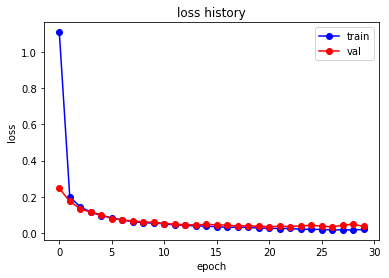

CNN1 normal he init training start
Best val Acc: 0.992262


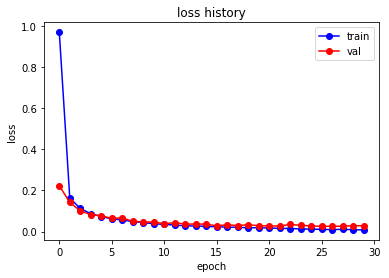

CNN2 training start
Best val Acc: 0.993810


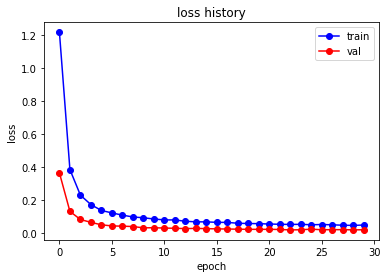

CNN3 training start
Best val Acc: 0.993214


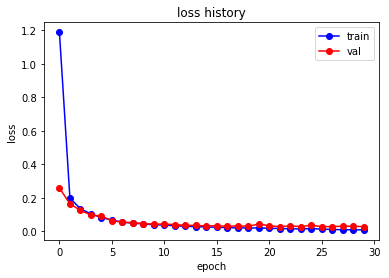

In [27]:
#train
for i, cnn in enumerate([CNN1, CNN2, CNN3]):
    model = cnn().to(device)
    criterion = nn.CrossEntropyLoss() #손실함수
    optimizer = optim.Adam(model.parameters(), lr = 0.001) #Adam 사용
    
    print(f"{cnn.__name__} training start")
    train_model(model = model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer, num_epochs = 30)
    plt.plot(train_loss_history, 'bo-', label = 'train')
    plt.plot(val_loss_history, 'ro-', label = 'val')
    plt.title('loss history')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    if i == 0: #Normal He initialization 경우
        model = cnn().to(device)
        model.apply(weights_init) #weight initialization(He)
        criterion = nn.CrossEntropyLoss() #손실함수
        optimizer = optim.Adam(model.parameters(), lr = 0.001) #Adam 사용
    
        print(f"{cnn.__name__} normal he init training start")
        train_model(model = model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer, num_epochs = 30)
        plt.plot(train_loss_history, 'bo-', label = 'train')
        plt.plot(val_loss_history, 'ro-', label = 'val')
        plt.title('loss history')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

## 학습 결과
 - weight initialzation 방법을 변경한 모델이 기본 모델보다 높은 정확도를 보여줬다
 - batchnorm과 dropout을 사용한 모델이 기본 모델보다 높은 정확도를 보여줬다
 - 활성화 함수로 Leakyrelu를 사용한 모델은 기본 모델보다 높은 정확도를 보여줬다
 - 최고 성능 모델: batchnorm & dropout model(CNN2)

## Transfer Learning(전이학습)
 - Transfer Learning이란: Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. (출처: google wiki)
 - 우수한 모델을 통한 전이학습을 적용하기 위해 kaggle의 Mnist문제(수업예제 데이터로 학습하는 모델 kaggle competition data x) 선택 https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy
 - 위 캐글 notebook을 참고해 model을 설계하고, 다른 데이터로 학습 시킨 후 현재 모델에 적용 후 학습 
 - 위 캐글에서는 입력으로 받는 numpy 배열을 pillow패키지를 활용해서 사진이미지로 변환 후 torchvision을 통해 data augmentation과정을 거쳐 overfitting 문제를 해결하려 했다
 - data augmentation과정을 이용하여 학습된 parameter들을 활용해 현재 모델에 학습해 위상변화에 강한 모델 생성
 - competition에 제출한 전이학습 csv파일의 점수가 기본학습 csv파일의 점수보다 높았다
 - -> 위상변화에 강한가? competition 점수는 높았지만, 두 모델 모두 99%이상의 정확도를 보여줘서 정확도의 차이가 적었다. 따라서 'Data augmentation을 한 전이학습 모델이 위상변화에 강하다'라는 결론은
   좀 더 검증이 필요하다가 생각된다.  

In [28]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )

                

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x

In [100]:
#모델 생성 및 학습된 parameter 불러오기
model = Net().to(device)
model.load_state_dict(torch.load('pretrained.pth'))

<All keys matched successfully>

Epoch 0/49
----------
train Loss: 1.6785 Acc: 0.7476
val Loss: 0.1521 Acc: 0.9656

Epoch 1/49
----------
train Loss: 0.1799 Acc: 0.9547
val Loss: 0.0701 Acc: 0.9839

Epoch 2/49
----------
train Loss: 0.1063 Acc: 0.9722
val Loss: 0.0477 Acc: 0.9889

Epoch 3/49
----------
train Loss: 0.0755 Acc: 0.9796
val Loss: 0.0376 Acc: 0.9906

Epoch 4/49
----------
train Loss: 0.0593 Acc: 0.9838
val Loss: 0.0293 Acc: 0.9927

Epoch 5/49
----------
train Loss: 0.0484 Acc: 0.9863
val Loss: 0.0257 Acc: 0.9930

Epoch 6/49
----------
train Loss: 0.0424 Acc: 0.9886
val Loss: 0.0254 Acc: 0.9932

Epoch 7/49
----------
train Loss: 0.0435 Acc: 0.9875
val Loss: 0.0249 Acc: 0.9935

Epoch 8/49
----------
train Loss: 0.0428 Acc: 0.9880
val Loss: 0.0247 Acc: 0.9935

Epoch 9/49
----------
train Loss: 0.0416 Acc: 0.9887
val Loss: 0.0241 Acc: 0.9932

Epoch 10/49
----------
train Loss: 0.0403 Acc: 0.9887
val Loss: 0.0239 Acc: 0.9933

Epoch 11/49
----------
train Loss: 0.0407 Acc: 0.9890
val Loss: 0.0234 Acc: 0.9933

Ep

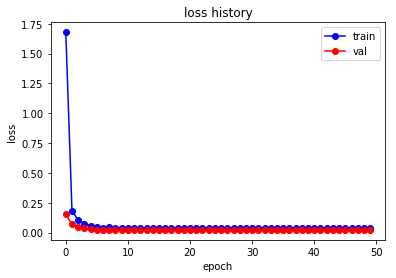

In [101]:
#학습 및 시각화
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.003) #Adam 사용

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #특정 step마다 lr을 gamma 비율만큼 감소시킨다

train_model(model = model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer, num_epochs = 50) #epoch 50

plt.plot(train_loss_history, 'bo-', label = 'train')
plt.plot(val_loss_history, 'ro-', label = 'val')
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 예측 및 제출 파일 생성

In [103]:
X_test = X_test.cuda()
with torch.no_grad():
    result = torch.max(model(X_test).data,1)[1]

In [104]:
result[:5]

tensor([8, 0, 5, 3, 8], device='cuda:0')

In [84]:
sample_submission = pd.read_csv('tobigs14-mnist-competition/sample_submission.csv')

In [105]:
result = result.cpu() #pandas series로 처리하기 위해서

In [86]:
sample_submission['Category'] = pd.Series(result)
sample_submission.to_csv("submission.csv", index = False)